custom MAPE ?

concat predicted demand be input


# Setup

In [ ]:
%pip install xgboost

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os

## Defining functions

In [3]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [4]:
def customized_MAPE(true_values, predicted_values):
    true_values, predicted_values = np.array(true_values), np.array(predicted_values)
    Mape = np.median(np.abs((true_values - predicted_values) / (true_values + 0.01)))
    return Mape

In [5]:
def load_data(train_size, test_size, force_update):
    path = 'datasets/'
    if os.path.exists(path) and (not force_update):
        pass
    else:
        urls = ['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet']
        
        for index in range(len(urls)):
            response = requests.get(urls[index])
            name = path + 'm' + str(index + 1) + '.parquet'

            with open(name, 'wb') as f:
                f.write(response.content)


    train_data = []
    test_data = []
    #train part
    for i in range(train_size):
        name = path + 'm' + str(i + 1) + '.parquet'
        data = pd.read_parquet(name)
        train_data.append(data)
    #test part
    for j in range(test_size):
        name = path + 'm' + str(j + train_size + 1) + '.parquet'
        data = pd.read_parquet(name)
        test_data.append(data)
    return train_data, test_data

In [25]:
def date_format_modifier(datas):  # Year/Month/Day
    modified_datas = []
    for data in datas:
        data['month'] = pd.DataFrame([int(date.strftime("%m")) for date in data['tpep_pickup_datetime']])
        data['tpep_pickup_datetime'] = pd.DataFrame([int(date.strftime("%d")) for date in data['tpep_pickup_datetime']])
        data = data.dropna()
        modified_datas.append(data)

    return modified_datas

In [244]:
def add_features(data):  # run after merging datasets and modifing date

    # Lag features
    data['prev_day_demand'] = data.groupby(['PULocationID', 'month'])['Demand'].shift(1)

    data['prev_week_demand'] = data.groupby(['PULocationID', 'month'])['Demand'].shift(7)
    data['2prev_week_demand'] = data.groupby(['PULocationID', 'month'])['Demand'].shift(14)

    # Summary features
    shifted = data['Demand'].shift(window_size - 1)
    window = shifted.rolling(window = window_size)
    data['pre_min_week_demand'] = window.min()
    data['pre_mean_week_demand'] = window.mean()
    data['pre_max_week_demand'] = window.max()

    shifted = data['Demand'].shift(2 * window_size - 1)
    window = shifted.rolling(window = window_size)
    data['2pre_min_week_demand'] = window.min()
    data['2pre_mean_week_demand'] = window.mean()
    data['2pre_max_week_demand'] = window.max()

    data = data.dropna()

    return data

In [27]:
def grouping_by(data, group_list):
    data_grouped = data.groupby(group_list, as_index = False)['extra'].count()
    data_grouped = data_grouped.rename(columns={'extra' : 'Demand'})

    return data_grouped

In [28]:
def clearing_data_noise(datas, months):
    clean_datas = []
    for index in range(len(datas)):
        month = months[index]
        data = datas[index]

        clean_data = data[[int(date.strftime("%m")) == month for date in data['tpep_pickup_datetime']]]
        clean_data = clean_data.dropna()
        clean_datas.append(clean_data)
    return clean_datas

In [40]:
def grid_search(model, test_parameters, train_data, cv = None):
    gs = GridSearchCV(estimator = model, param_grid = test_parameters, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs = -1)
    gs.fit(train_data[train_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [41]:
def point_predict(model, train_data, test_data):

    model.fit(train_data[train_list], train_data['Demand'])


    yhat_train = model.predict(train_data[train_list])
    yhat_test = model.predict(test_data[train_list])

    return yhat_train, yhat_test

In [97]:
def point_predict_visualizer(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data.copy(deep = True)
    predicted_test_df = test_data.copy(deep = True)
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test

    train_data = train_data.groupby('day_number')['Demand'].sum()
    test_data = test_data.groupby('day_number')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_number')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_number')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

In [32]:
def concating_data(datas):
    data_combined = pd.concat(datas, axis=0)
    return data_combined

In [61]:
def evaluation(model_name, train_data, test_data, yhat_train, yhat_test):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], yhat_train)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], yhat_train)
    evaluate(customized_MAPE, 'MAPE', train_data['Demand'], yhat_train)

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], yhat_test)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], yhat_test)
    evaluate(customized_MAPE, 'MAPE', test_data['Demand'], yhat_test)


In [34]:
def sort_metrics_values(metrics_values):
    metrics_train_values  = metrics_values['train']
    metrics_test_values = metrics_values['test']

    sorted_train_metrics = sorted(metrics_train_values, key=lambda x: x[1]['RMSE'], reverse = True)
    sorted_test_metrics = sorted(metrics_test_values, key=lambda x: x[1]['RMSE'], reverse = True)

    sorted_metrics_values = {'train': sorted_train_metrics, 'test': sorted_test_metrics}
    return sorted_metrics_values

In [42]:
def evaluate_each_location(fitted_model, train_data, test_data):
    metrics_values = {'train' : [], 'test': []}
    for loc_id in range(loc_id_num):
        sample_train_data = train_data[train_data['PULocationID'] == loc_id]
        sample_test_data = test_data[test_data['PULocationID'] == loc_id]
        if len(sample_train_data) != 0:
            yhat_train_sample = fitted_model.predict(sample_train_data[train_list])
            metrics_values['train'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_train_data["Demand"], yhat_train_sample)),
                                                      'MAE' : mean_absolute_error(sample_train_data["Demand"], yhat_train_sample)}])
        if len(sample_test_data) != 0:
            yhat_test_sample = fitted_model.predict(sample_test_data[train_list])
            metrics_values['test'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_test_data["Demand"], yhat_test_sample)),
                                                      'MAE' : mean_absolute_error(sample_test_data["Demand"], yhat_test_sample)}])
    return sort_metrics_values(metrics_values)

In [36]:
def get_locations_mean_demand(locations_id, data):
    sum_demands = []
    for location_id in locations_id:
        sum_demands.append({location_id : data[data['PULocationID'] == location_id]['Demand'].mean()})
    return sum_demands

In [52]:
def day_of_year_modifier(data):
    data['day_number'] = 0

    # Loop over each row in the DataFrame
    for index, row in data.iterrows():
        # Get the day and month values from the current row
        day = int(row['tpep_pickup_datetime'])
        month = int(row['month'])
        
        # Calculate the day number for the current row using datetime
        date = datetime.datetime(year=2023, month=month, day=day)
        day_number = (date - datetime.datetime(year=2023, month=1, day=1)).days + 1
        
        # Store the day number in the 'day_number' column for the current row
        data.at[index, 'day_number'] = day_number
    return data

# initialization and loading dataset

## Constant values

In [227]:
group_list = ['tpep_pickup_datetime', 'month', 'PULocationID']
train_list = ['day_number', 'prev_day_demand', 'prev_week_demand', 
              '2prev_week_demand', 'pre_min_week_demand', 
              'pre_mean_week_demand', 'pre_max_week_demand', 
              '2pre_min_week_demand', '2pre_mean_week_demand', '2pre_max_week_demand']
loc_id_num = 266
train_size = 3
test_size = 1
window_size = 7

## Load dataset

In [153]:
train_data, test_data = load_data(train_size, test_size, force_update = False)

# Preprocessing

In [154]:
train_data = clearing_data_noise(train_data, [1,2,3])
test_data = clearing_data_noise(test_data, [4])

In [155]:
train_date_modified = date_format_modifier(train_data)
test_date_modified = date_format_modifier(test_data)

In [156]:
train_data = concating_data(train_date_modified)
test_data = concating_data(test_date_modified)

In [157]:
train_grouped = grouping_by(train_data, group_list)
test_grouped = grouping_by(test_data, group_list)

In [245]:
train_feature_modified = add_features(train_grouped)
test_feature_modified = add_features(test_grouped)

In [ ]:
modified_train = day_of_year_modifier(train_feature_modified)
modified_test = day_of_year_modifier(test_feature_modified)

In [247]:
modified_train

,tpep_pickup_datetime,month,PULocationID,Demand,prev_day_demand,prev_week_demand,pre_min_week_demand,pre_mean_week_demand,pre_max_week_demand,2prev_week_demand,2pre_min_week_demand,2pre_mean_week_demand,2pre_max_week_demand,day_number
9178,15.0,1.0,1,19,7.0,12.0,2.0,8.285714,15.0,40.0,1.0,470.857143,1704.0,15
9180,15.0,1.0,4,206,270.0,150.0,2.0,290.571429,1534.0,146.0,1.0,249.142857,1704.0,15
9181,15.0,1.0,5,1,3.0,1.0,2.0,556.428571,1873.0,3.0,1.0,249.571429,1704.0,15
9182,15.0,1.0,6,3,3.0,2.0,2.0,697.571429,1873.0,1.0,1.0,249.285714,1704.0,15
9183,15.0,1.0,7,45,37.0,56.0,5.0,704.142857,1873.0,91.0,1.0,6.142857,12.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19654,31.0,3.0,261,505,575.0,582.0,1.0,399.571429,2735.0,538.0,1.0,673.714286,3136.0,90
19655,31.0,3.0,262,1425,1482.0,1404.0,1.0,400.857143,2735.0,1784.0,1.0,227.714286,1479.0,90
19656,31.0,3.0,263,2305,2075.0,2254.0,1.0,400.571429,2735.0,2826.0,3.0,228.000000,1479.0,90
19657,31.0,3.0,264,1187,1186.0,982.0,1.0,10.142857,29.0,1003.0,3.0,618.000000,2735.0,90


# Model Training

## **Linear Regression**

### Grid search to find best hyper parameters

In [231]:
model = Ridge()
best_params, best_score = grid_search(model, {'alpha':[1, 10, 100, 1000, 1000]}, modified_train, cv = 5)
print(best_params, best_score)

{'alpha': 1000} -125.34047129132429


In [232]:
model = Ridge(**best_params)
yhat_train, yhat_test = point_predict(model, modified_train, modified_test)

### Visualization

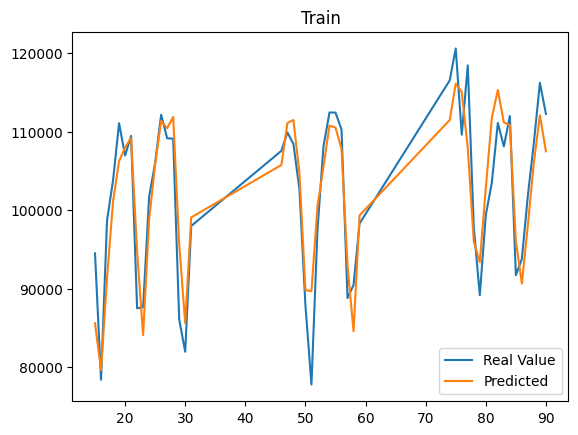

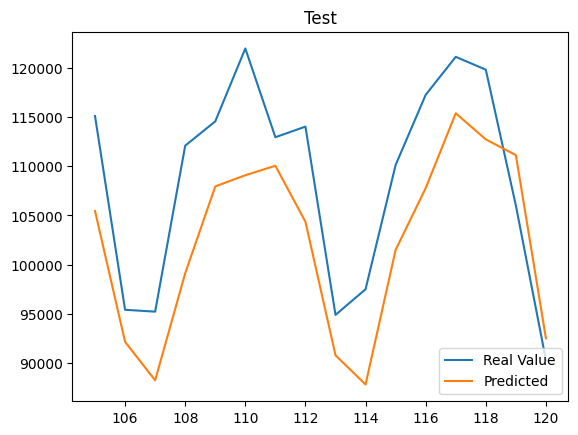

In [233]:
point_predict_visualizer(modified_train, modified_test, yhat_train, yhat_test)

### Evaluation

In [234]:
evaluation('Ridge Regression', modified_train, modified_test, yhat_train, yhat_test)  # for whole data

Ridge Regression train scores:
MAE : 44.67993037123676
MSE : 14400.660951431593
MAPE : 0.5649383085230726
Ridge Regression test scores:
MAE : 51.573603149705534
MSE : 11919.02224190176
MAPE : 1.8870331214797489


In [235]:
sorted_metrics_values = evaluate_each_location(model, modified_train, modified_test)  # for each location

In [236]:
sorted_metrics_values['train'][:10]

[[132, {'RMSE': 546.5644571054744, 'MAE': 458.143864541197}],
 [161, {'RMSE': 540.232166253809, 'MAE': 393.10389631014345}],
 [236, {'RMSE': 533.5935667269998, 'MAE': 375.528661063604}],
 [237, {'RMSE': 523.9795106013348, 'MAE': 383.55737873756124}],
 [138, {'RMSE': 424.07320367632855, 'MAE': 339.66938939226577}],
 [246, {'RMSE': 380.09437567945974, 'MAE': 271.99201201854885}],
 [230, {'RMSE': 369.93737439222616, 'MAE': 287.89034690500307}],
 [79, {'RMSE': 366.05401222834456, 'MAE': 261.0252588159439}],
 [163, {'RMSE': 303.54361230451894, 'MAE': 226.40087041715756}],
 [162, {'RMSE': 290.4408979726454, 'MAE': 196.32465770504146}]]

In [237]:
modified_train['Demand'].mean(), modified_test['Demand'].mean()

(510.1724209650582, 533.8421375921376)

In [238]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_train)

[{132: 5189.291666666667},
 {161: 4801.166666666667},
 {236: 4261.083333333333},
 {237: 4740.041666666667},
 {138: 3282.9375},
 {246: 1604.3541666666667},
 {230: 3496.9791666666665},
 {79: 2572.2916666666665},
 {163: 2982.5},
 {162: 3691.3541666666665}]

In [239]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_test)

[{132: 5987.125},
 {138: 3937.375},
 {237: 5255.5},
 {236: 4702.75},
 {142: 3876.1875},
 {161: 4867.625},
 {163: 3241.75},
 {162: 3713.5625},
 {170: 3190.1875},
 {234: 2934.8125}]

## **Gradient Boosting Regressor**

### Grid search to find best hyper parameters

In [80]:
param_test = {'max_depth':range(2,10,2), 'min_child_weight':range(1,6,2)}

params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'n_estimators':140, 'learning_rate':0.1, 'max_depth':5,
         'min_child_weight':1, 'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8, 'seed':27}

best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'max_depth': 2, 'min_child_weight': 5} -238.60198873503435


In [81]:
params.update(best_params)
param_test = {'gamma':[i/10.0 for i in range(0,5)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'gamma': 0.0} -238.60198873503435


In [85]:
params.update(best_params)
param_test = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'colsample_bytree': 0.6, 'subsample': 0.9} -237.0204546297031


In [87]:
params.update(best_params)
param_test = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'reg_alpha': 1} -237.02005974356038


In [90]:
params.update(best_params)
param_test = {'n_estimators':list(range(1000, 5001, 500)), 'learning_rate':[0.01]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.01, 'n_estimators': 1500} -236.59626847393665


In [95]:
params.update(best_params)
param_test = {'n_estimators':list(range(15000, 20001, 500)), 'learning_rate':[0.001]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.001, 'n_estimators': 15000} -236.53642284774014


### Training with costant parameters

In [240]:
dtrain_reg = xgb.DMatrix(modified_train[train_list].values, modified_train['Demand'].values, enable_categorical=True)
dtest_reg = xgb.DMatrix(modified_test[train_list].values, modified_test['Demand'].values, enable_categorical=True)

#params.update(best_params)
params = {'learning_rate': 0.001, 'n_estimators': 15000, 'reg_alpha': 1, 'colsample_bytree': 0.6, 
          'subsample': 0.9, 'gamma': 0.0, 'max_depth': 2, 'min_child_weight': 5}
model = xgb.XGBRegressor(**params)
yhat_train, yhat_test = point_predict(model, modified_train, modified_test)

### Visualization

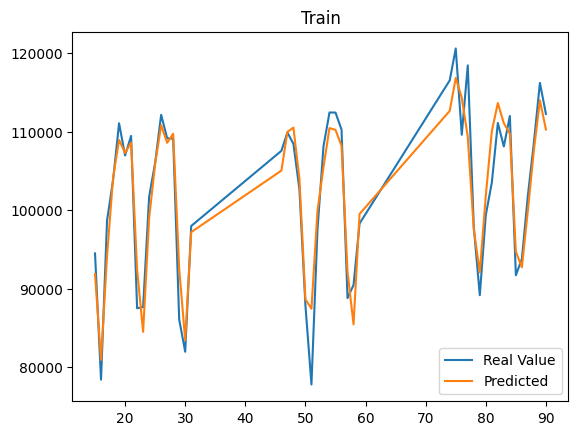

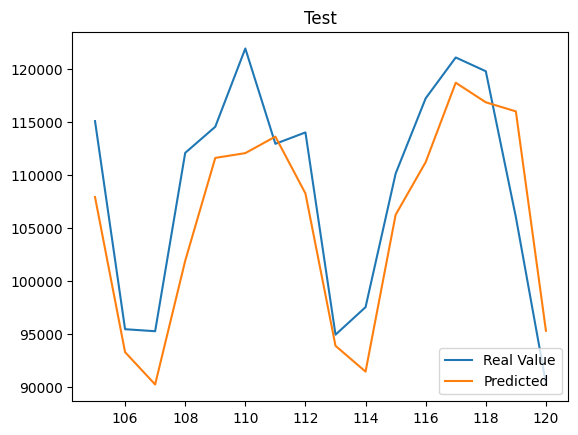

In [241]:
point_predict_visualizer(modified_train, modified_test, yhat_train, yhat_test)

### Evaluation

In [242]:
evaluation('Random Forest Regressor', modified_train, modified_test, yhat_train, yhat_test)  # for whole data

Random Forest Regressor train scores:
MAE : 37.556632261230874
MSE : 9919.205211414377
MAPE : 0.3276994231112904
Random Forest Regressor test scores:
MAE : 42.528461501601406
MSE : 12830.706782480358
MAPE : 0.2829636460682344


In [221]:
sorted_metrics_values = evaluate_each_location(model, modified_train, modified_test)  # for each location

In [222]:
sorted_metrics_values['train'][:10]

[[132, {'RMSE': 422.64299506754196, 'MAE': 349.4459584554036}],
 [161, {'RMSE': 416.3937350485587, 'MAE': 293.7652842203776}],
 [236, {'RMSE': 396.8968962683462, 'MAE': 286.80080159505206}],
 [138, {'RMSE': 391.1977242602484, 'MAE': 310.9748051961263}],
 [237, {'RMSE': 377.3192799883311, 'MAE': 284.56553649902344}],
 [246, {'RMSE': 342.07597410886393, 'MAE': 251.83304850260416}],
 [230, {'RMSE': 323.0439349046878, 'MAE': 250.4739532470703}],
 [79, {'RMSE': 302.0365096493131, 'MAE': 224.46369171142578}],
 [163, {'RMSE': 276.7473356136156, 'MAE': 197.01285807291666}],
 [140, {'RMSE': 260.82477863484047, 'MAE': 172.76912689208984}]]

In [223]:
modified_train['Demand'].mean(), modified_test['Demand'].mean()

(510.1724209650582, 533.8421375921376)

In [224]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_train)

[{132: 5189.291666666667},
 {161: 4801.166666666667},
 {236: 4261.083333333333},
 {138: 3282.9375},
 {237: 4740.041666666667},
 {246: 1604.3541666666667},
 {230: 3496.9791666666665},
 {79: 2572.2916666666665},
 {163: 2982.5},
 {140: 2122.5}]

In [225]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_test)

[{132: 5987.125},
 {138: 3937.375},
 {237: 5255.5},
 {236: 4702.75},
 {142: 3876.1875},
 {161: 4867.625},
 {162: 3713.5625},
 {170: 3190.1875},
 {163: 3241.75},
 {107: 2401.875}]